# Optimizing Affine Transforms
* Optimizing Affine transform paramaters using SGD and random restarts
* This notebook contains examples for rotations and random affine transforms.

In [14]:
import os
import sys
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image, ImageOps

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))

from utils.display import read_img_to_np, torch_to_np
from utils.norms import MNIST_norm
import model.model as module_arch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
from model.model import AffineVAE

device = torch.device("cuda:0")

from data_loader.data_loaders import make_generators_MNIST, make_generators_MNIST_CTRNFS

In [15]:
def get_model_loaders_config(PATH, old_gpu='cuda:0', new_gpu='cuda:1'):
    """PATH: path to dir where training results of a run are saved"""
    PATH = Path(PATH)
    config_loc = PATH / 'config.json'
    weight_path = PATH / 'model_best.pth'
    config = json.load(open(config_loc))
    
    
    def get_instance(module, name, config, *args):
        return getattr(module, config[name]['type'])(*args, **config[name]['args'])

    data_loader = get_instance(module_data, 'data_loader', config)['train']
    valid_data_loader = get_instance(module_data, 'data_loader', config)['val']
    model = get_instance(module_arch, 'arch', config)
    model = model.to(torch.device(new_gpu))
    checkpoint = torch.load(weight_path, map_location={'cuda:0': 'cuda:1'})
    state_dict = checkpoint['state_dict']
    
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)

    model.load_state_dict(state_dict)
    model = model.to(device).eval()
    
    loss_fn = get_instance(module_loss, 'loss', config)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    return model, data_loader, valid_data_loader, loss_fn, metric_fns, config


In [16]:
def pad_to_size(img, new_size):
    delta_width = new_size - img.size()[1]
    delta_height = new_size - img.size()[2]
    pad_width = delta_width //2
    pad_height = delta_height //2
    img = F.pad(img, (pad_height, pad_height, pad_width, pad_width), 'constant', 0)
    return img

def rotate_mnist_batch(x, return_size=40, fixed_rotation=None):
    """Rotate batch without squishing the img. Pad all imgs to same size"""
    batch_size = x.shape[0]
    rot_x = torch.zeros((batch_size, 1, return_size, return_size))
    for i in range(batch_size):
        img = TF.to_pil_image(x[i, :, :])
        if fixed_rotation:
            img = TF.rotate(img, fixed_rotation)

        img = transforms.ToTensor()(img)
        if return_size:
            img = pad_to_size(img, return_size)
        # MNIST norm, wrong because imgs are padded
        img = transforms.Normalize((0.1307,), (0.3081,))(img)
        rot_x[i, :, :, :] = img
    return rot_x
    

def get_vae_MNIST_perf(model, data_loader, loss_fn, metric_fns, device, fixed_rotation, return_size):
    """Evaluate performance on MNIST Dataset using a given rotation
    
    Dataloader should be MNISTCustomTRNFS with size=28x28, unnormalized, not rotated"""

    with torch.cuda.device(device.index):
        model = model.to(device)
        model.eval()

        total_loss = 0.0
        total_metrics = torch.zeros(len(metric_fns))

        with torch.no_grad():
            for i, (data, target) in enumerate(tqdm(data_loader)):
                batch_size = data.shape[0]
                new_data = rotate_mnist_batch(data, return_size=40, fixed_rotation=fixed_rotation)
                new_data, target = new_data.to(device), target.to(device)
                output = model(new_data, deterministic=True)

                # computing loss, metrics on test set
                loss = loss_fn(output, new_data)
                total_loss += loss.item() * batch_size
                for i, metric in enumerate(metric_fns):
                    total_metrics[i] += metric(output, new_data) * batch_size

        n_samples = len(data_loader.sampler)
        log = {'loss': total_loss / n_samples}
        log.update({met.__name__ : total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
        return log

## Optimizing rotation using SGD and random restarts
* Can compute gradient of $\theta$ to optimize the rotation to minimize VAE loss
* Random restarts are needed because this tends to get caught in local optimum

In [28]:
def AFFINE_MNIST_rot_perf(model, data_loader, loss_fn, device, fixed_rotation, 
                          optimize=False, iterations=0, num_rand_restarts=200, num_imgs=1000):
    """Evaluate performance on MNIST Dataset using a given rotation
    Dataloader should be MNISTCustomTRNFS with size=28x28, unnormalized, not rotated"""

    with torch.cuda.device(device.index):
        model = model.to(device)
        model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                batch_size = data.shape[0]
                rot_x = rotate_mnist_batch(data, return_size=40, fixed_rotation=fixed_rotation)
                rot_x, target = rot_x.to(device), target.to(device)
                if optimize:
                    best_affine, loss = affine_model.optimize_rotation(rot_x, num_times=num_rand_restarts, 
                                                                       iterations=iterations)
                else:
                    output = model(rot_x, deterministic=True, theta=0.0)
                    loss = loss_fn(output, rot_x).item()

                total_loss += loss * batch_size
                if i>num_imgs:
                    break

        n_samples = len(data_loader.sampler)
        log = {'loss': total_loss / num_imgs}
        return log

### Grab decent AVAE and dataloaders

In [29]:
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model = affine_model.to(device)

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=1, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)

In [34]:
for iterations in [2, 5, 10, 20, 40]:
    log = AFFINE_MNIST_rot_perf(affine_model, data_loaders['val'], loss_fn, device, fixed_rotation=45, 
                                optimize=True, iterations=iterations, num_rand_restarts=1, num_imgs=1000)
    print(f"Iterations: {iterations} Loss: {log['loss']}")

Iterations: 2 Loss: 669.2090291748046
Iterations: 5 Loss: 664.2208488464355
Iterations: 10 Loss: 658.0452225341797
Iterations: 20 Loss: 660.5350748901367
Iterations: 40 Loss: 653.7899044799805


In [26]:
for rand_restarts in [5, 10, 20, 40]:
    log = AFFINE_MNIST_rot_perf(affine_model, data_loaders['val'], loss_fn, device, fixed_rotation=45, 
                                optimize=True, iterations=20, num_rand_restarts=rand_restarts, num_imgs=1000)
    print(f"Rand Restarts: {rand_restarts} Loss: {log['loss']}")

Rand Restarts: 5 Loss: 6.292737271118164
Rand Restarts: 10 Loss: 6.367885220336914
Rand Restarts: 20 Loss: 6.184860906982422
Rand Restarts: 40 Loss: 6.0255543212890625


## Performance of optimization over different rotations

In [ ]:
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model = affine_model.to(device)

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=1, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)

results = pd.DataFrame()
results_opt = pd.DataFrame()
for rotation in range(0, 180, 15):
    print(f'rotation: {rotation}')
    log = AFFINE_MNIST_rot_perf(affine_model, data_loaders['val'], loss_fn, device, fixed_rotation=rotation, 
                                optimize=False, iterations=0, num_rand_restarts=0, num_imgs=1000)
    log['rotation'] = rotation
    results = results.append(log, ignore_index=True)
    
    log_opt = AFFINE_MNIST_rot_perf(affine_model, data_loaders['val'], loss_fn, device, fixed_rotation=rotation, 
                                optimize=True, iterations=10, num_rand_restarts=40, num_imgs=1000)
    log_opt['rotation'] = rotation
    results_opt = results_opt.append(log_opt, ignore_index=True)

results.to_csv('/media/rene/code/equivariance/results/affine_rot_nonopt_sgd20_r40.csv')
results_opt.to_csv('/media/rene/code/equivariance/results/affine_rot_opt_sgd20_r40.csv')

fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss'], label="VAE")
ax.plot(results_opt['rotation'], results_opt['loss'], label="AVAE")

ax.set(xlabel='Rotation', ylabel='VAE Loss',
       title='Effect of optimizing rotation on VAE loss')
ax.legend(loc='best')

plt.savefig('/media/rene/code/equivariance/imgs/rotation_opt_sgd20_r40.png', bbox='tight')
plt.show()

rotation: 0


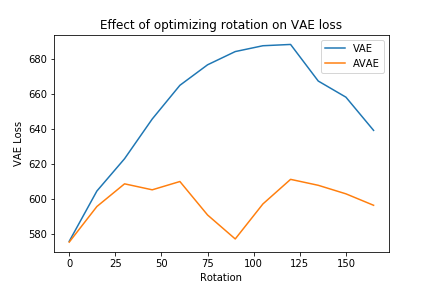

In [3]:
result = Image.open('/media/rene/code/equivariance/imgs/rotation_opt_sgd20_r40.png')
display(result)

## Optimize for Affine Transforms

In [99]:
def affine_mnist_batch(x, rand_affine=True, rand_translate=False,
                      degrees=(-180, 180), scale=(.75, 1.5), shear=(-55, 55)):
    return_size=40
    batch_size = x.shape[0]
    x_affine = torch.zeros((batch_size, 1, return_size, return_size))
    for i in range(batch_size):
        img = TF.to_pil_image(x[i, :, :])
        if rand_affine:
            if rand_translate:
                translate = (.5, .5)
            else:
                translate = (0, 0)
            trans = transforms.RandomAffine(degrees=degrees, translate=(0, 0), 
                                            scale=scale, shear=shear, fillcolor=0)
        img = trans(img)
        img = transforms.ToTensor()(img)
        img = pad_to_size(img, return_size)
        img = transforms.Normalize((0.1307,), (0.3081,))(img)
        x_affine[i, :, :, :] = img
    return x_affine


def AFFINE_MNIST_perf(model, data_loader, loss_fn, device, rand_translate=False, 
                      optimize=False, iterations=0, num_rand_restarts=200, num_batches=1000):
    with torch.cuda.device(device.index):
        model = model.to(device)
        model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                batch_size = data.shape[0]
                affine_x = affine_mnist_batch(data, rand_affine=True, rand_translate=rand_translate)
                affine_x, target = affine_x.to(device), target.to(device)
                
                if optimize:
                    for img_idx in range(batch_size):
                        best_affine, loss = affine_model.optimize_affine(affine_x[img_idx, :, :, :].unsqueeze(0), 
                                                                         num_times=num_rand_restarts, 
                                                                         iterations=iterations, 
                                                                         translate=rand_translate)
                        total_loss += loss
                    
                else:
                    output = model(affine_x, deterministic=True, theta=0.0)
                    loss = loss_fn(output, affine_x).item()
                    total_loss += loss*batch_size
                    
                if i>num_batches:
                    break

        n_samples = len(data_loader.sampler)
        log = {'loss': total_loss / num_imgs}
        return log

### Look at Affine Batch and how the optimization works

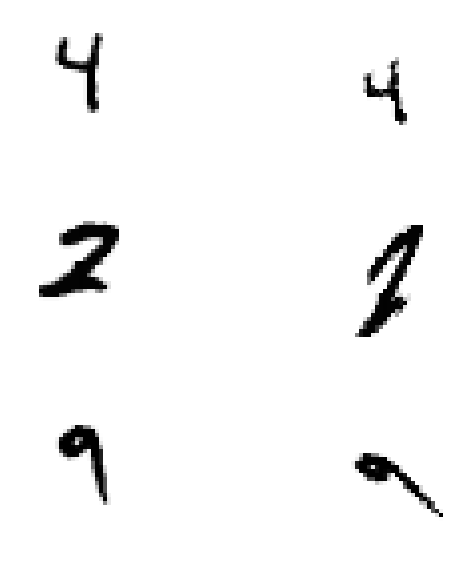

In [61]:
def display_batch(x, recon_x):
    """Display tensor images"""
    fig, ax = plt.subplots(3, 2, sharex='col', sharey='row',figsize=(10,10))
    for i in range(3):
        ax[i, 0].imshow(torch_to_np(x[i, :, :]), cmap='Greys',  interpolation='nearest')
        ax[i, 1].imshow(torch_to_np(recon_x[i, :, :]), cmap='Greys',  interpolation='nearest')
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
    plt.show()
    
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
    
x, y = next(iter(data_loaders['val']))
x_affine = affine_mnist_batch(x, rand_affine=True, rand_translate=False)

display_batch(x, x_affine)

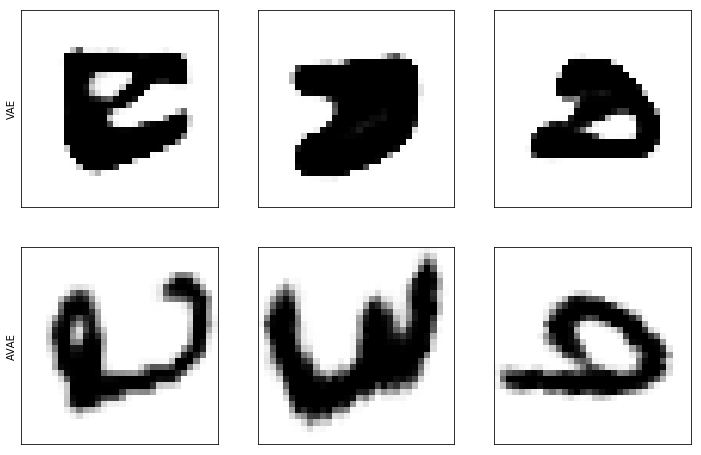

In [79]:
def display_vae_avae_affine(avae_model, files_dict_loc, num_samples=6, num_times=10, save_loc=None):
    
    data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
    
    x, y = next(iter(data_loaders['val']))
    x_affine = affine_mnist_batch(x, rand_affine=True, rand_translate=False,
                                  degrees=(90, 90), scale=(1.5, 1.5), shear=(-30, -30))

    fig, ax = plt.subplots(2, num_samples, sharex=True, sharey=True, figsize=(12,8))
    row_names = ['VAE', 'AVAE']
    
    for i in range(num_samples):
        idx = random.randint(0, x.size()[0])
        img = x[idx, :, :, :].unsqueeze(0)
        img = img.to(device)
        affine_img = x_affine[idx, :, :, :].unsqueeze(0)
        affine_img = affine_img.to(device)

        affine_vae_output = avae_model.VAE(affine_img, deterministic=True)
        
        best_affine_params, loss = affine_model.optimize_affine(affine_img, 
                                                                num_times=num_times, 
                                                                iterations=30, 
                                                                translate=False)
        
        affine_avae_output = avae_model(affine_img,  deterministic=True, affine_params=best_affine_params)
            
        ax[0, i].imshow(torch_to_np(affine_vae_output[0][:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')
        ax[1, i].imshow(torch_to_np(affine_avae_output[0][:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')

        ax[0, 0].set_ylabel(row_names[0])
        ax[1, 0].set_ylabel(row_names[1])

    plt.xticks([])
    plt.yticks([])
    
    if save_loc:
        plt.savefig(save_loc, bbox_inches='tight')
    
    plt.show()


config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model = affine_model.to(device)

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'

# display_vae_avae_affine(affine_model, files_dict_loc, num_samples=3, num_times=120,
#                        save_loc='/media/rene/code/equivariance/imgs/vae_avae_affine_ex.png')

In [ ]:
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model = affine_model.to(device)

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=1, num_workers=2, 
                                            return_size=28, rotation_range=None, normalize=False)

results = pd.DataFrame()
num_batches = 1000


log = {}
log['loss_vae'] = AFFINE_MNIST_perf(affine_model, data_loaders['val'], loss_fn, device, 
                                    rand_translate=False, optimize=False, 
                                    iterations=0, num_rand_restarts=0, num_batches=num_batches)


log['loss_avae'] = AFFINE_MNIST_perf(affine_model, data_loaders['val'], loss_fn, device, 
                                     rand_translate=False, optimize=True, 
                                     iterations=30, num_rand_restarts=120, num_batches=num_batches)

results = results.append(log, ignore_index=True)

results.to_csv('/media/rene/code/equivariance/results/affine_L8_rand_affine_sgd30_r120_1000t.csv')

In [ ]:
results

In [3]:
rot_hist_loc = '/media/rene/data/equivariance/mnist/batch_avae_mnist_L8_rotate_save_hist/the_only_rot_history.pkl'

with open(rot_hist_loc, 'rb') as f:
    rot_hist = pickle.load(f)

In [5]:
len(rot_hist)

1